<a href="https://colab.research.google.com/github/woncoh1/END/blob/main/Assignment_Session_7_Sentiment_Analysis_using_LSTM_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructions

- Download the StanfordSentimentAnalysis Dataset from this [link](http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip) (it might be troubling to download it, so force download on chrome). Use "**datasetSentences.txt**" and "**sentiment_labels.txt**" files from the zip you just downloaded as your dataset. This dataset contains just over 10,000 pieces of Stanford data from HTML files of Rotten Tomatoes. The sentiments are rated between 1 and 25, where one is the most negative and 25 is the most positive. 
  - See **0. Download data** and **1. Process data**
- Use **back translation**, **`random_swap`**, and **`random_delete`** to augment the data you are training on. 
  - See *Data Augmentation* section of **1. Process data**
- Train your model and try and achieve **60%+ accuracy**. Upload your colab file on git with the the **training logs**. 
  - After 10 epochs, validation accuracy of **80.58%** and testing accuracy of **79.96%**

# 0. Download data

In [221]:
# download and unzip dataset

!wget -O stanford_sentiment_treebank.zip http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
!unzip stanford_sentiment_treebank.zip

--2020-12-10 13:55:43--  http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip [following]
--2020-12-10 13:55:43--  https://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6372817 (6.1M) [application/zip]
Saving to: ‘stanford_sentiment_treebank.zip’

stanford_sentiment_ 100%[===================>]   6.08M  13.0MB/s    in 0.5s    

2020-12-10 13:55:43 (13.0 MB/s) - ‘stanford_sentiment_treebank.zip’ saved [6372817/6372817]

Archive:  stanford_sentiment_treebank.zip
replace stanfordSentimentTreebank/datasetSentences.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: 

# 1. Process data

## Dataset Preview

(From README.txt)

**Stanford Sentiment Treebank V1.0**

This is the dataset of the paper:

*Recursive Deep Models for Semantic Compositionality Over a Sentiment Treebank
Richard Socher, Alex Perelygin, Jean Wu, Jason Chuang, Christopher Manning, Andrew Ng and Christopher Potts
Conference on Empirical Methods in Natural Language Processing (EMNLP 2013)*

If you use this dataset in your research, please cite the above paper.

`@incollection{SocherEtAl2013:RNTN,
title = {{Parsing With Compositional Vector Grammars}},
author = {Richard Socher and Alex Perelygin and Jean Wu and Jason Chuang and Christopher Manning and Andrew Ng and Christopher Potts},
booktitle = {{EMNLP}},
year = {2013}}`

This file includes:
1. original_rt_snippets.txt contains 10,605 processed snippets from the original pool of Rotten Tomatoes HTML files. Please note that some snippet may contain multiple sentences.

2. dictionary.txt contains all phrases and their IDs, separated by a vertical line |.

3. **sentiment_labels.txt** contains all phrase ids and the corresponding sentiment labels, separated by a vertical line.
Note that you can recover the 5 classes by mapping the positivity probability using the following cut-offs:  
[0, 0.2], (0.2, 0.4], (0.4, 0.6], (0.6, 0.8], (0.8, 1.0]  
for very negative, negative, neutral, positive, very positive, respectively.
Please note that phrase ids and sentence ids are not the same.

4. SOStr.txt and STree.txt encode the structure of the parse trees. 
STree encodes the trees in a parent pointer format. Each line corresponds to each sentence in the datasetSentences.txt file. The Matlab code of this paper will show you how to read this format if you are not familiar with it.

5. **datasetSentences.txt** contains the sentence index, followed by the sentence string separated by a tab. These are the sentences of the train/dev (validation)/test sets.

6. datasetSplit.txt contains the sentence index (corresponding to the index in datasetSentences.txt file) followed by the set label separated by a comma:  
	1 = train  
	2 = test  
	3 = dev (validation)  

Please note that the datasetSentences.txt file has more sentences/lines than the original_rt_snippet.txt. 
Each row in the latter represents a snippet as shown on RT, whereas the former is each sub sentence as determined by the Stanford parser.

For comparing research and training models, please use the provided train/dev (validation)/test splits.

In [222]:
# load and inspect dataset

import pandas as pd

dataset_sentences = pd.read_csv('stanfordSentimentTreebank/datasetSentences.txt', sep='\t')
print(dataset_sentences.shape, '\n', dataset_sentences.head())

print()

sentiment_labels = pd.read_csv('stanfordSentimentTreebank/sentiment_labels.txt', sep='|')                
sentiment_labels = sentiment_labels.rename(columns={'phrase ids': 'phrase_id', 
                                                    'sentiment values': 'sentiment_value'})
print(sentiment_labels.shape, '\n', sentiment_labels.head())

(11855, 2) 
    sentence_index                                           sentence
0               1  The Rock is destined to be the 21st Century 's...
1               2  The gorgeously elaborate continuation of `` Th...
2               3                     Effective but too-tepid biopic
3               4  If you sometimes like to go to the movies to h...
4               5  Emerges as something rare , an issue movie tha...

(239232, 2) 
    phrase_id  sentiment_value
0          0          0.50000
1          1          0.50000
2          2          0.44444
3          3          0.50000
4          4          0.42708


AxesSubplot(0.125,0.125;0.775x0.755)


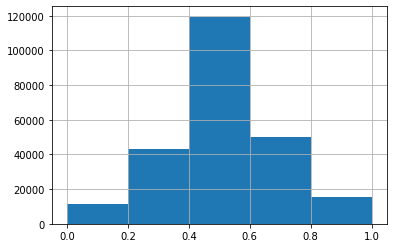

In [223]:
# histogram of sentiment values for phrases
# [0,   0.2]: very negative
# (0.2, 0.4]: negative
# (0.4, 0.6]: neutral
# (0.6, 0.8]: positive 
# (0.8, 1.0]: very positive

print(sentiment_labels.sentiment_value.hist(bins=5))

## Mappping Sentiments from Phrases to Sentences

In [224]:
# compute sentiment values for sentences using sentiment values of phrases

sentence_sentiment = dataset_sentences
phrase_sentiment = dict(zip(list(sentiment_labels.phrase_id), 
                            list(sentiment_labels.sentiment_value)))

# STree.txt connects sentences with phrases
with open('stanfordSentimentTreebank/STree.txt') as file:
    stree = file.readlines()
stree = [line.strip().split('|') for line in stree] 

from statistics import mean

# average sentiments per sentence (otherwise long sentences get high sentiments)
sentiments = [mean(phrase_sentiment[int(phrase_id)] for phrase_id in phrase_ids) 
              for phrase_ids in stree]
# define neutral sentiment as values within [0.5, 0.55) 
sentiments = [2 if sentiment >= 0.5 and sentiment < 0.55 else sentiment 
              for sentiment in sentiments]
# all negative sentiment values to 0, all positive sentiment values to 1
sentiments = [int(round(sentiment)) 
              for sentiment in sentiments]
# concatenate sentence sentiment values with corresponding sentence texts
sentence_sentiment['sentiment_value'] = sentiments

sentence_sentiment

,sentence_index,sentence,sentiment_value
0,1,The Rock is destined to be the 21st Century 's...,0
1,2,The gorgeously elaborate continuation of `` Th...,0
2,3,Effective but too-tepid biopic,0
3,4,If you sometimes like to go to the movies to h...,0
4,5,"Emerges as something rare , an issue movie tha...",0
...,...,...,...
11850,11851,A real snooze .,0
11851,11852,No surprises .,0
11852,11853,We 've seen the hippie-turned-yuppie plot befo...,0
11853,11854,Her fans walked out muttering words like `` ho...,0


In [225]:
# show percentage of each sentiment class
# 0: negative
# 1: positive
# 2: neutral

print((100 * sentence_sentiment.sentiment_value.value_counts(normalize=True)).map('{:0.2f}%'.format))

0    56.71%
1    28.36%
2    14.93%
Name: sentiment_value, dtype: object


In [226]:
# rename and select columns

sentence_sentiment = sentence_sentiment.rename(columns={'sentence': 'tweets', 'sentiment_value': 'labels'})
sentence_sentiment = sentence_sentiment[['tweets', 'labels']]
sentence_sentiment

,tweets,labels
0,The Rock is destined to be the 21st Century 's...,0
1,The gorgeously elaborate continuation of `` Th...,0
2,Effective but too-tepid biopic,0
3,If you sometimes like to go to the movies to h...,0
4,"Emerges as something rare , an issue movie tha...",0
...,...,...
11850,A real snooze .,0
11851,No surprises .,0
11852,We 've seen the hippie-turned-yuppie plot befo...,0
11853,Her fans walked out muttering words like `` ho...,0


## Defining Fields

Now we shall be defining LABEL as a LabelField, which is a subclass of Field that sets sequential to False (as it’s our numerical category class). TWEET is a standard Field object, where we have decided to use the spaCy tokenizer and convert all the text to lower‐case.

In [227]:
# Import Library
import random
import torch, torchtext
from torchtext import data 

# Manual Seed
SEED = 43
torch.manual_seed(SEED)

In [228]:
Tweet = data.Field(sequential=True, tokenize='spacy', batch_first=True, include_lengths=True)
Label = data.LabelField(tokenize='spacy', is_target=True, batch_first=True, sequential=False)

Having defined those fields, we now need to produce a list that maps them onto the list of rows that are in the CSV:

In [229]:
fields = [('tweets', Tweet),('labels',Label)]

Armed with our declared fields, lets convert from pandas to list to torchtext. We could also use TabularDataset to apply that definition to the CSV directly but showing an alternative approach too.

In [230]:
# Creating dataset
#twitterDataset = data.TabularDataset(path="tweets.csv", format="CSV", fields=fields, skip_header=True)

example = [data.Example.fromlist([sentence_sentiment.tweets[i],sentence_sentiment.labels[i]], fields) for i in range(sentence_sentiment.shape[0])] 
twitterDataset = data.Dataset(example, fields)

## Splitting Datasets

Finally, we can split into training, testing, and validation sets by using the split() method:

In [231]:
(train, valid, test) = twitterDataset.split(split_ratio=[0.6, 0.2, 0.2], random_state=random.seed(SEED))

In [232]:
(len(train), len(valid), len(test))

(7113, 2371, 2371)

An example from the dataset:

In [233]:
vars(train.examples[10])

{'labels': 2,
 'tweets': ['In',
  'other',
  'words',
  ',',
  'about',
  'as',
  'bad',
  'a',
  'film',
  'you',
  "'re",
  'likely',
  'to',
  'see',
  'all',
  'year',
  '.']}

## Data Augmentation

In [234]:
# import libraries and prepare sentence text

import random
# for back translation
!pip install google_trans_new
import google_trans_new
from google_trans_new import google_translator
# for word tokenization
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Back Translation**

In [235]:
# translate a sentence to a random language,
# and translate back to original language

def back_translate(sentence, p=0.1):
  # do nothing with probability of 1-p
  if random.uniform(0,1) > p:
    return sentence

  # combine tokenized sentence into one string
  sentence = ' '.join(sentence)

  # instantiate translator
  translator = google_translator()

  # choose a target language
  available_langs = list(google_trans_new.LANGUAGES.keys()) 
  trans_lang = random.choice(available_langs) 
  #print(f"Translating to {google_trans_new.LANGUAGES[trans_lang]}")

  # translate to the target language
  translations = translator.translate(sentence, lang_tgt=trans_lang) 
  #print(translations)

  # translate back to original language
  translations_en_random = translator.translate(translations, lang_src=trans_lang, lang_tgt='en') 
  #print(translations_en_random)

  # select only one translation
  if len(translations_en_random) > 1:
    translations_en_random = translations_en_random[0]

  return word_tokenize(translations_en_random)

**Random Deletion**

In [236]:
# randomly delete words from a sentence with a given probability

def random_deletion(sentence, p=0.5): 
    # return if single word
    if len(sentence) == 1: 
        return sentence
    # delete words
    remaining = list(filter(lambda x: random.uniform(0,1) > p, sentence)) 
    # if nothing left, sample a random word
    if len(remaining) == 0: 
        return [random.choice(sentence)] 
    else:
        return remaining

**Random Swap**

In [237]:
# randomly swap a pair of words in a sentence for a given # of times

def random_swap(sentence, n=5): 
    if len(sentence) < 2:
      return sentence
    length = range(len(sentence)) 
    for _ in range(n):
        idx1, idx2 = random.sample(length, 2)
        sentence[idx1], sentence[idx2] = sentence[idx2], sentence[idx1] 
    return sentence

**Carry Out Data Augmentation**

In [238]:
for example in train.examples: 
  example.tweets = back_translate(example.tweets, p=0.01)
  example.tweets = random_deletion(example.tweets, p=0.1)
  example.tweets = random_swap(example.tweets, n=1)

## Building Vocabulary

At this point we would have built a one-hot encoding of each word that is present in the dataset—a rather tedious process. Thankfully, torchtext will do this for us, and will also allow a max_size parameter to be passed in to limit the vocabulary to the most common words. This is normally done to prevent the construction of a huge, memory-hungry model. We don’t want our GPUs too overwhelmed, after all. 

Let’s limit the vocabulary to a maximum of 10,000 words in our training set:


In [239]:
MAX_VOCAB_SIZE = 10_000

Tweet.build_vocab(train, max_size = MAX_VOCAB_SIZE)
Label.build_vocab(train)

By default, torchtext will add two more special tokens, <unk> for unknown words and <pad>, a padding token that will be used to pad all our text to roughly the same size to help with efficient batching on the GPU.

In [240]:
print('Size of input vocab : ', len(Tweet.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Tweet.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  10002
Size of label vocab :  3
Top 10 words appreared repeatedly : [('.', 5969), (',', 5273), ('the', 4519), ('and', 3323), ('of', 3244), ('a', 3208), ('to', 2260), ('-', 2036), ("'s", 1905), ('is', 1866)]
Labels :  defaultdict(<function _default_unk_index at 0x7fb426d8d9d8>, {0: 0, 1: 1, 2: 2})


**Lots of stopwords!!**

## Making batches

Now we need to create a data loader to feed into our training loop. Torchtext 
provides the BucketIterator method that will produce what it calls a Batch, which is almost, but not quite, like the data loader we used on images.

But at first declare the device we are using.

In [241]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [242]:
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train, valid, test), 
    batch_size = 32, 
    sort_key = lambda x: len(x.tweets),
    sort_within_batch=True, 
    device = device)

Save the vocabulary for later use

In [243]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Tweet.vocab.stoi, tokens)

# 2. Build the model

We use the Embedding and LSTM modules in PyTorch to build a simple model for classifying tweets.

In this model we create three layers. 
1. First, the words in our tweets are pushed into an Embedding layer, which we have established as a 300-dimensional vector embedding. 
2. That’s then fed into a 2 stacked-LSTMs with 100 hidden features (again, we’re compressing down from the 300-dimensional input like we did with images). We are using 2 LSTMs for using the dropout.
3. Finally, the output of the LSTM (the final hidden state after processing the incoming tweet) is pushed through a standard fully connected layer with three outputs to correspond to our three possible classes (negative, positive, or neutral).

In [244]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 n_layers, dropout):
        
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                               hidden_dim, 
                               num_layers=n_layers, 
                               dropout=dropout,
                               batch_first=True)
        # try using nn.GRU or nn.RNN here and compare their performances
        # try bidirectional and compare their performances
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
    
        # Hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)   
        
        # Final activation function (softmax)
        output = F.softmax(dense_outputs[0], dim=1)
            
        return output

In [245]:
# Define hyperparameters
size_of_vocab = len(Tweet.vocab)
embedding_dim = 300
num_hidden_nodes = 100
num_output_nodes = 3
num_layers = 2
dropout = 0.2

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

print(model)

classifier(
  (embedding): Embedding(10002, 300)
  (encoder): LSTM(300, 100, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=100, out_features=3, bias=True)
)


In [246]:
# No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,242,503 trainable parameters


# 3. Train, evaluate, and test the model

## Model Training and Evaluation

**Preparation**  

First define the optimizer and loss function, and then push the two into cuda (if available).  

Also define an accuracy metric.

In [247]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc

The main thing to be aware of in this new training loop is that we have to reference `batch.tweets` and `batch.labels` to get the particular fields we’re interested in; they don’t fall out quite as nicely from the enumerator as they do in torchvision.

**Training Loop**

In [248]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        tweet, tweet_lengths = batch.tweets   
        
        # convert to 1D tensor
        predictions = model(tweet, tweet_lengths).squeeze()  
        
        # compute the loss
        loss = criterion(predictions, batch.labels)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.labels)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Evaluation Loop**

In [249]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            tweet, tweet_lengths = batch.tweets
            
            # convert to 1d tensor
            predictions = model(tweet, tweet_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.labels)
            acc = binary_accuracy(predictions, batch.labels)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Let's Train and Evaluate**

In [250]:
N_EPOCHS = 10
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

	Train Loss: 1.011 | Train Acc: 54.40%
	 Val. Loss: 0.989 |  Val. Acc: 56.21% 

	Train Loss: 0.977 | Train Acc: 56.70%
	 Val. Loss: 0.976 |  Val. Acc: 56.38% 

	Train Loss: 0.900 | Train Acc: 62.97%
	 Val. Loss: 0.845 |  Val. Acc: 70.12% 

	Train Loss: 0.806 | Train Acc: 74.52%
	 Val. Loss: 0.810 |  Val. Acc: 73.67% 

	Train Loss: 0.779 | Train Acc: 76.99%
	 Val. Loss: 0.837 |  Val. Acc: 70.12% 

	Train Loss: 0.763 | Train Acc: 78.24%
	 Val. Loss: 0.787 |  Val. Acc: 75.83% 

	Train Loss: 0.750 | Train Acc: 79.56%
	 Val. Loss: 0.795 |  Val. Acc: 73.79% 

	Train Loss: 0.735 | Train Acc: 82.14%
	 Val. Loss: 0.767 |  Val. Acc: 78.42% 

	Train Loss: 0.721 | Train Acc: 83.73%
	 Val. Loss: 0.756 |  Val. Acc: 79.71% 

	Train Loss: 0.712 | Train Acc: 84.32%
	 Val. Loss: 0.747 |  Val. Acc: 80.58% 



In [251]:
# test model using testing dataset

model.load_state_dict(torch.load('saved_weights.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.753 | Test Acc: 79.96%


## Model Testing with User Input

In [252]:
# load weights and tokenizer
path='./saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

# inference 
import spacy
nlp = spacy.load('en')

def classify_tweet(tweet):
    
    categories = {0: "Negative", 1:"Positive", 2:"Neutral"}
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(tweet)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)

    _, pred = torch.max(prediction, 1) 
    
    return categories[pred.item()]

In [253]:
classify_tweet("A valid explanation for why Trump won't let women on the golf course.")

'Positive'

In [254]:
classify_tweet("Obama has called the GOP budget social Darwinism. Nice try, but they believe in social creationism.")

'Negative'

In [255]:
classify_tweet("In his teen years, Obama has been known to use marijuana and cocaine.")

'Negative'